# AndroidLogs model preparation

## 1. Load data

In [1]:
import numpy as np
import pandas as pd
import os
import codecs

In [2]:
dataset_path = 'logs'
malicious_subdir = 'malicious'
benign_subdir = 'benign'

In [3]:
output_dir = os.path.join('..', 'rest_server')
output_model_filename = 'AndroidLogsClf.h5'
tokenizer_filename = 'tokenizer'

In [4]:
output_model_path = os.path.join(output_dir, output_model_filename)
tokenizer_path = os.path.join(output_dir, tokenizer_filename)

In [5]:
severity_levels = ['V', 'D', 'I', 'W', 'E', 'F', 'S']
n_sev_levels = len(severity_levels) + 1 # for unknown severity

In [6]:
benign_label = 0
malicious_label = 1

### Read files

In [7]:
def read_whole_file(path):
    with codecs.open(path, encoding='utf-8', errors='ignore') as f:
        content = f.read()
    return content

def log_path(dir_name, file_name):
    return os.path.join(dataset_path, dir_name, file_name)

In [8]:
def flatmap(self, func, preserve_index=False):
    rows = []
    columns = self.columns
    
    if preserve_index:
        for idx, row in self.iterrows():
            multrows = [[idx] + [v for v in r] for r in func(row)]
            rows.extend(multrows)
        columns = ['Id'] + list(columns)
    else:
        for _, row in self.iterrows():
            multrows = func(row)
            rows.extend(multrows)
            
    return pd.DataFrame.from_records(rows, columns=columns)

pd.DataFrame.flatmap = flatmap

In [9]:
def load_data():
    logs_benign = np.array([(read_whole_file(log_path(benign_subdir, file)), benign_label) for file in os.listdir(os.path.join(dataset_path, benign_subdir))])
    logs_malicious = np.array([(read_whole_file(log_path(malicious_subdir, file)), malicious_label) for file in os.listdir(os.path.join(dataset_path, malicious_subdir))])
    
    df = pd.DataFrame(np.vstack([logs_benign, logs_malicious]), columns=['log', 'label'])
    
    return df.flatmap(lambda row: [(line, row['label']) for line in row['log'].split("\n")], preserve_index=True)

In [10]:
data = load_data()

In [11]:
data.head()

,Id,log,label
0,0,--------- beginning of /dev/log/main\r,0
1,0,E/logwrapper( 41): executing /system/bin/e2f...,0
2,0,E/logwrapper( 48): executing /system/bin/e2f...,0
3,0,I/qemu-props( 54): connected to 'boot-proper...,0
4,0,I/qemu-props( 54): receiving..\r,0


In [12]:
len(data)

248082

In [13]:
data.Id.value_counts() # lengths of specific files

84    5046
39    4539
20    4292
19    4288
41    4249
      ... 
70     993
62     729
43     328
80     197
26     133
Name: Id, Length: 86, dtype: int64

### Preprocess

#### Filter out  blank and header lines

In [14]:
def filter_out_irrelevant_lines(data):
    mask = data['log'].map(lambda line: len(line.strip()) > 0 and not line.startswith('-'))
    return data[mask]

In [15]:
data = filter_out_irrelevant_lines(data)
data.head()

,Id,log,label
1,0,E/logwrapper( 41): executing /system/bin/e2f...,0
2,0,E/logwrapper( 48): executing /system/bin/e2f...,0
3,0,I/qemu-props( 54): connected to 'boot-proper...,0
4,0,I/qemu-props( 54): receiving..\r,0
5,0,I/qemu-props( 54): received: dalvik.vm.execu...,0


#### Split severity and messages

In [16]:
def extract_severity(data):
    data[['severity', 'log']] = data['log'].str.split('/', expand=True, n=1)

In [17]:
extract_severity(data)
data.head()

,Id,log,label,severity
1,0,logwrapper( 41): executing /system/bin/e2fsc...,0,E
2,0,logwrapper( 48): executing /system/bin/e2fsc...,0,E
3,0,qemu-props( 54): connected to 'boot-properti...,0,I
4,0,qemu-props( 54): receiving..\r,0,I
5,0,qemu-props( 54): received: dalvik.vm.executi...,0,I


#### One-hot encode severity

In [18]:
def one_hot_encode_severity(data):
    new_columns = pd.get_dummies(data['severity'].astype(pd.CategoricalDtype(categories=severity_levels)), prefix='sev_', dummy_na=True)
    return pd.concat([data.drop('severity', axis=1), new_columns], axis=1)

In [19]:
data = one_hot_encode_severity(data)
data.head()

,Id,log,label,sev__V,sev__D,sev__I,sev__W,sev__E,sev__F,sev__S,sev__nan
1,0,logwrapper( 41): executing /system/bin/e2fsc...,0,0,0,0,0,1,0,0,0
2,0,logwrapper( 48): executing /system/bin/e2fsc...,0,0,0,0,0,1,0,0,0
3,0,qemu-props( 54): connected to 'boot-properti...,0,0,0,1,0,0,0,0,0
4,0,qemu-props( 54): receiving..\r,0,0,0,1,0,0,0,0,0
5,0,qemu-props( 54): received: dalvik.vm.executi...,0,0,0,1,0,0,0,0,0


#### Tokenize messages

In [20]:
from tensorflow.keras.preprocessing.text import Tokenizer
import pickle

In [21]:
tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n0123456789')
tokenizer.fit_on_texts(data['log'])

In [22]:
tokenizer.get_config()

{'num_words': None,
 'filters': '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n0123456789',
 'lower': True,
 'split': ' ',
 'char_level': False,
 'oov_token': None,
 'document_count': 247824,
 'word_counts': '{"logwrapper": 1509, "executing": 1466, "system": 38074, "bin": 2477, "e": 7031, "fsck": 949, "failed": 10552, "no": 8682, "such": 3640, "file": 5641, "or": 3367, "directory\\r": 1609, "qemu": 970, "props": 787, "connected": 1935, "to": 18820, "\'boot": 60, "properties\'": 60, "qemud": 60, "service": 7729, "\\r": 145599, "receiving": 363, "received": 11977, "dalvik": 934, "vm": 154, "execution": 60, "mode": 504, "int": 1089, "portable\\r": 60, "heapsize": 60, "m\\r": 60, "sf": 203, "lcd": 128, "density": 352, "hw": 493, "mainkeys": 61, "debug": 1968, "debuggerd": 61, "feb": 54, "fake": 123, "camera": 731, "back\\r": 123, "netd": 202, "starting\\r": 116, "exiting": 140, "properties": 135, "set": 517, "interfacecontroller": 79, "warning": 141, "dlopen": 118, "library": 790, "lib": 5137, "libn

In [23]:
def tokenize_log(data):
    bag_of_words = tokenizer.texts_to_matrix(data['log'])
    log_df = pd.DataFrame(bag_of_words, index=data.index, columns=[f'word{i}' for i in range(bag_of_words.shape[1])])
    data_without_log = data.drop(['log'], axis=1)
    return pd.concat([data_without_log, log_df], axis=1, join='inner')

In [24]:
data = tokenize_log(data)
data.head()

,Id,label,sev__V,sev__D,sev__I,sev__W,sev__E,sev__F,sev__S,sev__nan,...,word7912,word7913,word7914,word7915,word7916,word7917,word7918,word7919,word7920,word7921
1,0,0,0,0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0,0,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
n_words = len(tokenizer.index_word) + 1
n_words

7922

In [26]:
with open(f'{tokenizer_path}.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### Group lines

In [49]:
import tensorflow as tf

In [50]:
def group_data(data):
    data_np = data.to_numpy().astype(np.float32)
    labels = tf.constant(data_np[np.unique(data_np[:,0], return_index=True)[1], 1])
    samples = tf.RaggedTensor.from_value_rowids(values=data_np[:,2:], value_rowids=data_np[:,0])
    return samples, labels

In [51]:
data, labels = group_data(data)

In [52]:
data.shape, labels.shape

(TensorShape([50, None, 5581]), TensorShape([50]))

#### Train-test splitting

In [55]:
def train_test_split(X, y, test_size):
    data_len = y.shape[0]
    train_len = int(data_len * (1.0-test_size))
    
    indices = tf.random.shuffle(tf.constant(range(data_len)))
    X_train = tf.gather(X, indices[:train_len])
    X_test = tf.gather(X, indices[train_len:])
    y_train = tf.gather(y, indices[:train_len])
    y_test = tf.gather(y, indices[train_len:])
    
    return X_train, X_test, y_train, y_test

In [56]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)

In [57]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15)

In [58]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

(TensorShape([34, None, 5581]),
 TensorShape([6, None, 5581]),
 TensorShape([10, None, 5581]),
 TensorShape([34]),
 TensorShape([6]),
 TensorShape([10]))

## 2. Build model

In [59]:
from tensorflow import keras
from tensorflow.keras import layers

In [68]:
model = keras.Sequential()

model.add(layers.Input(shape=(None,n_words + n_sev_levels)))
model.add(layers.LSTM(128))
model.add(layers.Dense(64))
model.add(layers.Dense(1, activation='sigmoid'))

In [69]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [70]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 128)               2923520   
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,931,841
Trainable params: 2,931,841
Non-trainable params: 0
_________________________________________________________________


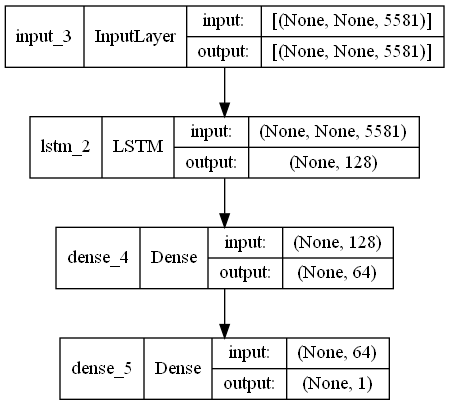

In [71]:
keras.utils.plot_model(model, show_shapes=True)

## 3. Train model

In [72]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [73]:
callbacks = [EarlyStopping(monitor='val_loss', patience=5),
            ModelCheckpoint(output_model_path, save_best_only=True, save_weights_only=False)]

In [74]:
history = model.fit(X_train,
                    y_train,
                    batch_size=1,
                    epochs=30,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks)

Epoch 1/30
34/34 [==============================] - 302s 9s/step - loss: 0.4292 - accuracy: 0.8529 - val_loss: 0.9465 - val_accuracy: 0.6667
Epoch 2/30
34/34 [==============================] - 302s 9s/step - loss: 0.3223 - accuracy: 0.8824 - val_loss: 1.1881 - val_accuracy: 0.6667
Epoch 3/30
34/34 [==============================] - 306s 9s/step - loss: 0.1479 - accuracy: 0.9706 - val_loss: 1.5405 - val_accuracy: 0.6667
Epoch 4/30
34/34 [==============================] - 302s 9s/step - loss: 0.0561 - accuracy: 0.9706 - val_loss: 2.5652 - val_accuracy: 0.6667
Epoch 5/30
34/34 [==============================] - 312s 9s/step - loss: 0.0537 - accuracy: 0.9706 - val_loss: 1.1040 - val_accuracy: 0.6667
Epoch 6/30
34/34 [==============================] - 306s 9s/step - loss: 0.0174 - accuracy: 1.0000 - val_loss: 1.9474 - val_accuracy: 0.6667


In [76]:
model.evaluate(X_test, y_test, batch_size=1)

10/10 [==============================] - 14s 1s/step - loss: 0.8024 - accuracy: 0.7000


[0.8024280667304993, 0.699999988079071]